# Import

In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [31]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [32]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

In [33]:
import cv2
from PIL import Image
import tf_explain
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, LayerNormalization

# Image preprocessing 

In [11]:

input_dir = r'C:\Users\USER\Desktop\Ready data\eample\or'  #original images
output_dir = r'C:\Users\USER\Desktop\Ready data\eample'  #save augmented images


os.makedirs(output_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=15,         #rotation range
    width_shift_range=0.1,    #horizontal shifts
    height_shift_range=0.1,   #vertical shifts
    shear_range=0.1,          #shear
    zoom_range=[0.95, 1.05],   #zoom range
    horizontal_flip=True,      #horizontal flipping
    brightness_range=(0.9, 1.1), #brightness 
    fill_mode='reflect'        #reflect to avoid stretching pixels
)


def resize_image(img, target_size=(224, 224)):
    
    img.thumbnail(target_size, Image.LANCZOS)
    new_img = Image.new("RGB", target_size, (0, 0, 0))  #black 
    #center the image
    
    new_img.paste(img, ((target_size[0] - img.width) // 2,
                        (target_size[1] - img.height) // 2))
    return new_img

#image formats
valid_image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]

#load images
for img_name in os.listdir(input_dir):
    
    #check file format
    
    if any(img_name.lower().endswith(ext) for ext in valid_image_extensions):
        img_path = os.path.join(input_dir, img_name)
        
        
        img = Image.open(img_path).convert('RGB') 
        img = resize_image(img)  
        img_array = np.array(img)  
        
        
        img_array = np.expand_dims(img_array, 0)

        
        for i, batch in enumerate(datagen.flow(img_array, batch_size=1,
                                               save_to_dir=output_dir,
                                               save_prefix='aug',
                                               save_format='jpeg')):
            if i >= 4:  # how many time to generate augmented images per original image
                break




# Vaildation preprosessing

In [53]:

def resize_image(img, target_size=(448, 448)):
    
    img.thumbnail(target_size, Image.LANCZOS)
    new_img = Image.new("RGB", target_size, (0, 0, 0))  
    
    new_img.paste(img, ((target_size[0] - img.width) // 2,
                        (target_size[1] - img.height) // 2))
    return new_img



input_dir = r'C:\Users\USER\Desktop\main dataset\Model_1\vaild\Milk_thistle\com'   #original images
output_dir = r'C:\Users\USER\Desktop\Ready data\Model_5_resnet152_448\vaild1\Milk_thistle'  #save augmented images


os.makedirs(output_dir, exist_ok=True)


def process_and_save_image_with_padding(image_path, output_path, target_size=(448, 448)):

    img = Image.open(image_path).convert('RGB')
    
 
    img = resize_image(img, target_size)
    
   
    img.save(output_path, format='JPEG')


for img_name in os.listdir(input_dir):

    img_path = os.path.join(input_dir, img_name)
    
    
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        
        output_path = os.path.join(output_dir, img_name)
        
       
        process_and_save_image_with_padding(img_path, output_path)

# Data generator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# D

train_dir = r'C:\Users\USER\Desktop\Ready data\Model_3\train'
valid_dir = r'C:\Users\USER\Desktop\Ready data\Model_3\vaild'


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)


valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)




train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)


valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)




Found 9544 images belonging to 7 classes.
Found 1121 images belonging to 7 classes.


# class Balance

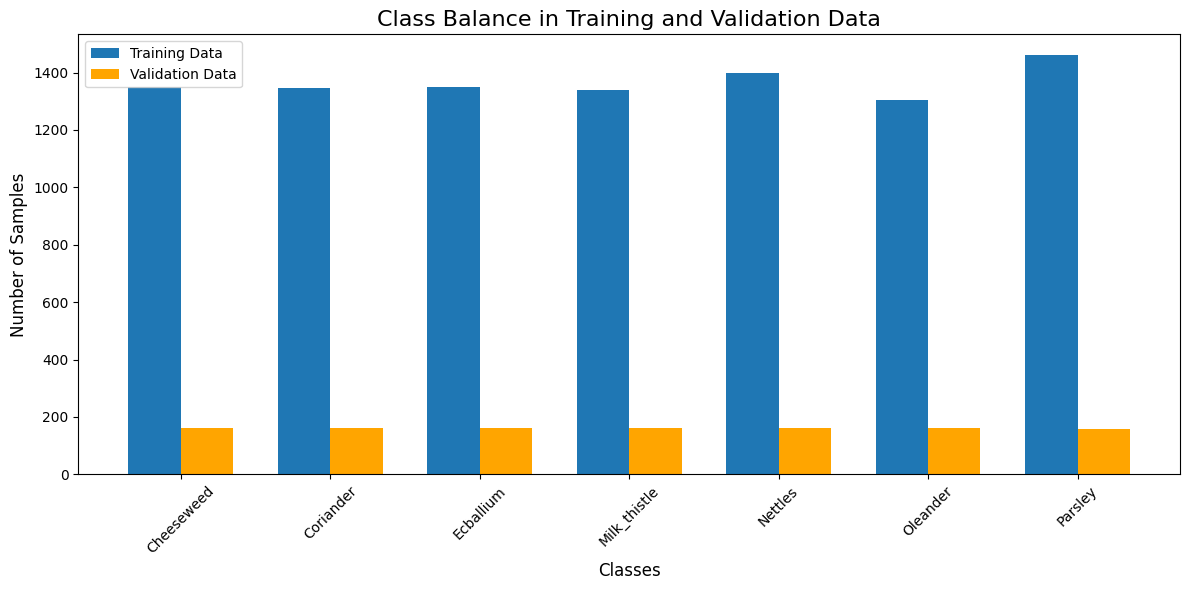

In [29]:
import matplotlib.pyplot as plt
import numpy as np


train_class_counts = np.bincount(train_generator.classes)
valid_class_counts = np.bincount(valid_generator.classes)


class_labels = list(train_generator.class_indices.keys())


plt.figure(figsize=(12, 6))
bar_width = 0.35  # Width of bars


plt.bar(
    np.arange(len(class_labels)) - bar_width / 2,
    train_class_counts,
    bar_width,
    label="Training Data"
)


plt.bar(
    np.arange(len(class_labels)) + bar_width / 2,
    valid_class_counts,
    bar_width,
    label="Validation Data",
    color='orange'
)


plt.title("Class Balance in Training and Validation Data", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()


plt.show()


# Main model

#### We have tested multiple models, such as ResNet152, using larger input image sizes 448 x 448


In [30]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)  
x = BatchNormalization()(x)
#x = LayerNormalization()(x)
x = Dropout(0.6)(x) 


x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)  
x = BatchNormalization()(x)
#x = LayerNormalization()(x)
x = Dropout(0.6)(x)


predictions = Dense(7, activation='softmax', kernel_regularizer=l2(1e-4))(x)


model = Model(inputs=base_model.input, outputs=predictions)

#### Freeze all layers in the base model

In [31]:
for layer in base_model.layers:
    layer.trainable = False



model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])



#### Unfreeze the last few layers of the base model

In [32]:

for layer in base_model.layers[-5:]:  
    layer.trainable = True

#CategoricalCrossentropy(label_smoothing=0.1)
#  loss='categorical_crossentropy'


model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy', metrics=['accuracy'])


#### Model Summary

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

#### balance class weight

In [34]:



class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)


class_weights = dict(enumerate(class_weights_array))


print(class_weights)

{0: 1.0114455277660026, 1: 1.0121964153144554, 2: 1.0114455277660026, 3: 1.019004911381593, 4: 0.9738775510204082, 5: 1.0463764938055038, 6: 0.9338551859099804}


#### foces more on Coriander & Parsley

In [24]:
class_weights[1] *= 1.5  # Coriander كوبرة
class_weights[6] *= 1.5  # Parsley بقدونس


print("Updated Class Weights:", class_weights)


Updated Class Weights: {0: 0.9731723675385647, 1: 1.042684679505605, 2: 0.9663669663669664, 3: 0.9800742992232354, 4: 0.9951306494753446, 5: 0.9750033597634726, 6: 1.6168932471584578}


In [35]:

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]



history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=200,
    callbacks=callbacks,
    class_weight=class_weights
    
)



Epoch 1/200
299/299 [==============================] - ETA: 0s - loss: 2.0264 - accuracy: 0.3967
Epoch 1: val_loss improved from inf to 1.07326, saving model to best_model.h5
299/299 [==============================] - 29s 87ms/step - loss: 2.0264 - accuracy: 0.3967 - val_loss: 1.0733 - val_accuracy: 0.6476 - lr: 1.0000e-04
Epoch 2/200
299/299 [==============================] - ETA: 0s - loss: 1.1721 - accuracy: 0.6141
Epoch 2: val_loss improved from 1.07326 to 0.91325, saving model to best_model.h5
299/299 [==============================] - 25s 83ms/step - loss: 1.1721 - accuracy: 0.6141 - val_loss: 0.9133 - val_accuracy: 0.7172 - lr: 1.0000e-04
Epoch 3/200
299/299 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.7090
Epoch 3: val_loss improved from 0.91325 to 0.83339, saving model to best_model.h5
299/299 [==============================] - 24s 82ms/step - loss: 0.8778 - accuracy: 0.7090 - val_loss: 0.8334 - val_accuracy: 0.7556 - lr: 1.0000e-04
Epoch 4/200
299/2

# Testing

#### Testing a saved model

In [9]:
model_path = r'C:\Users\USER\Desktop\Ready data\Model_3_new\model_resnet50_best_of_best_7_1.h5'
model1 = load_model(model_path)

In [11]:



test_dir = r'C:\Users\USER\Desktop\Ready data\test'



test_datagen = ImageDataGenerator(
   
    preprocessing_function=preprocess_input  
)



test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Found 157 images belonging to 7 classes.


In [15]:

val_loss, val_accuracy = model1.evaluate(valid_generator, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


test_loss, test_accuracy = model1.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



36/36 [==============================] - 2s 40ms/step - loss: 0.5235 - accuracy: 0.8930
Validation Loss: 0.5234847664833069
Validation Accuracy: 0.8929527401924133
5/5 [==============================] - 1s 157ms/step - loss: 0.7322 - accuracy: 0.8471
Test Loss: 0.7321891188621521
Test Accuracy: 0.8471337556838989


# Vaildation matrix

In [17]:

true_classes = valid_generator.classes  


class_labels = list(valid_generator.class_indices.keys())  





In [18]:
predictions = model1.predict(valid_generator)


predicted_classes = np.argmax(predictions, axis=1)






36/36 [==============================] - 2s 44ms/step


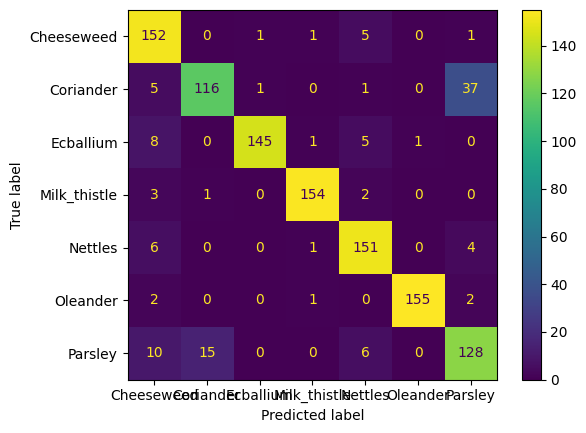

In [19]:
cm = confusion_matrix(true_classes, predicted_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')




In [20]:


y_true = true_classes
y_pred = np.argmax(model1.predict(valid_generator), axis=1)
print(classification_report(y_true, y_pred, target_names=class_labels))


36/36 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

  Cheeseweed       0.82      0.95      0.88       160
   Coriander       0.88      0.72      0.79       160
   Ecballium       0.99      0.91      0.94       160
Milk_thistle       0.97      0.96      0.97       160
     Nettles       0.89      0.93      0.91       162
    Oleander       0.99      0.97      0.98       160
     Parsley       0.74      0.81      0.77       159

    accuracy                           0.89      1121
   macro avg       0.90      0.89      0.89      1121
weighted avg       0.90      0.89      0.89      1121



# Test matrix

In [21]:
true_classes = test_generator.classes  


class_labels = list(test_generator.class_indices.keys()) 





In [22]:
predictions = model1.predict(test_generator)


predicted_classes = np.argmax(predictions, axis=1)



5/5 [==============================] - 1s 219ms/step


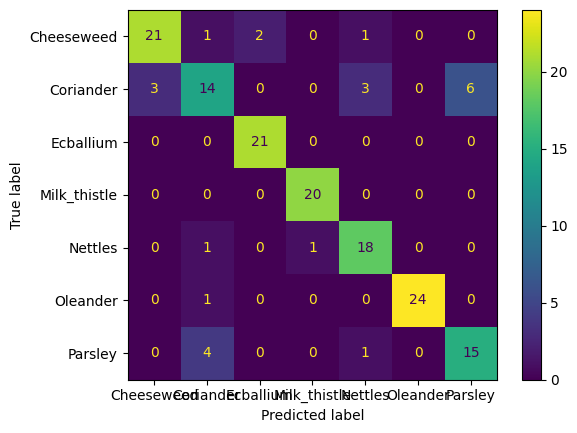

In [23]:
cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')




In [24]:


y_true = true_classes
y_pred = np.argmax(model1.predict(test_generator), axis=1)
print(classification_report(y_true, y_pred, target_names=class_labels))



5/5 [==============================] - 1s 127ms/step
              precision    recall  f1-score   support

  Cheeseweed       0.88      0.84      0.86        25
   Coriander       0.67      0.54      0.60        26
   Ecballium       0.91      1.00      0.95        21
Milk_thistle       0.95      1.00      0.98        20
     Nettles       0.78      0.90      0.84        20
    Oleander       1.00      0.96      0.98        25
     Parsley       0.71      0.75      0.73        20

    accuracy                           0.85       157
   macro avg       0.84      0.86      0.85       157
weighted avg       0.84      0.85      0.84       157



#### ROC Curve

5/5 [==============================] - 1s 172ms/step


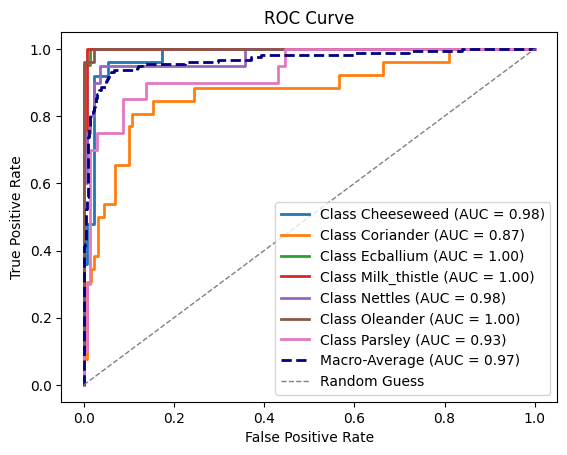

AUC-ROC Scores for Each Class:
Cheeseweed: 0.9800
Coriander: 0.8743
Ecballium: 0.9993
Milk_thistle: 0.9978
Nettles: 0.9763
Oleander: 0.9991
Parsley: 0.9318
Macro-Average AUC-ROC: 0.9673


In [27]:

#true class labels
true_classes = test_generator.classes


class_labels = list(test_generator.class_indices.keys())  


# Predict
y_pred = model1.predict(test_generator)  






true_classes_one_hot = to_categorical(true_classes, num_classes=len(class_labels))


#AUC-ROC for each class

fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(true_classes_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

#macro-average AUC-ROC for multi-class
fpr["macro"], tpr["macro"], _ = roc_curve(true_classes_one_hot.ravel(), y_pred.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



# Plot the ROC curves
plt.figure()
for i in range(len(class_labels)):
    plt.plot(
        fpr[i], tpr[i], lw=2, label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})"
    )
plt.plot(
    fpr["macro"], tpr["macro"], color="navy", linestyle="--", lw=2, label=f"Macro-Average (AUC = {roc_auc['macro']:.2f})"
)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Print AUC-ROC scores
print("AUC-ROC Scores for Each Class:")
for i, label in enumerate(class_labels):
    print(f"{label}: {roc_auc[i]:.4f}")
print(f"Macro-Average AUC-ROC: {roc_auc['macro']:.4f}")


#### Viewing misclassified images

25/25 [==============================] - 1s 59ms/step


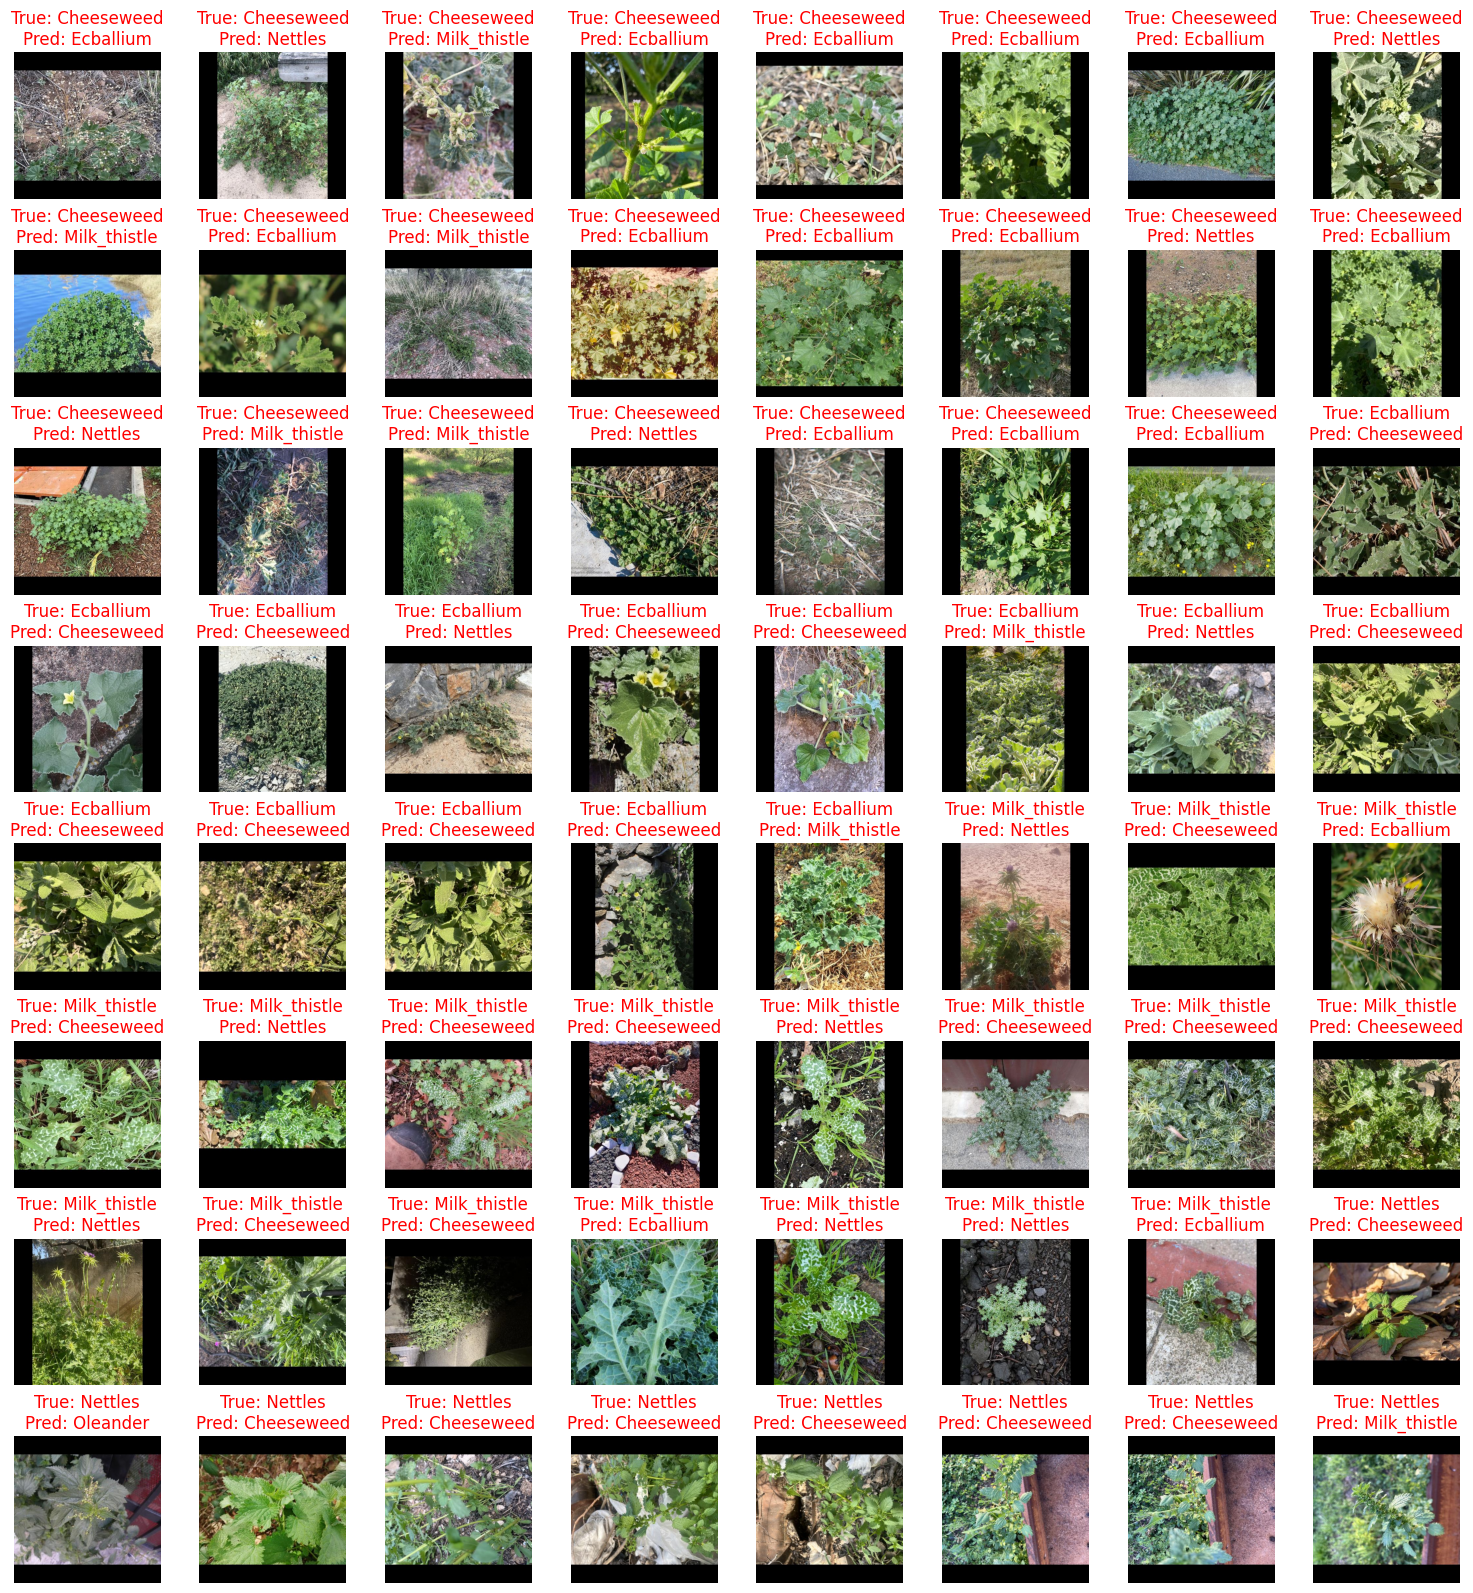

In [109]:
class_labels = list(valid_generator.class_indices.keys())

#true class label
true_classes = valid_generator.classes
predictions = model.predict(valid_generator)
predicted_classes = np.argmax(predictions, axis=1)

#misclassified
misclassified_indices = np.where(predicted_classes != true_classes)[0]

#file paths 
validation_filenames = valid_generator.filepaths




def plot_misclassified_images_all_classes(validation_filenames, misclassified_indices, true_classes, predicted_classes, class_labels, num_images=64):

    
    num_rows = int(np.ceil(num_images / 8))  
    num_cols = min(num_images, 8) 
    
    plt.figure(figsize=(15, num_rows * 2))  
    
    for i, idx in enumerate(misclassified_indices[:num_images]):
        #Load 
        
        img_path = validation_filenames[idx]
        try:
            img = plt.imread(img_path)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            continue
        
        #true and predict
        true_label = class_labels[true_classes[idx]]
        predicted_label = class_labels[predicted_classes[idx]]
        
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
    
    plt.tight_layout()
    plt.show()


plot_misclassified_images_all_classes(validation_filenames, misclassified_indices, true_classes, predicted_classes, class_labels, num_images=64)


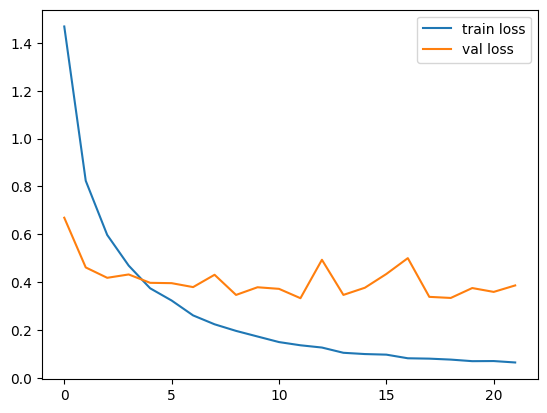

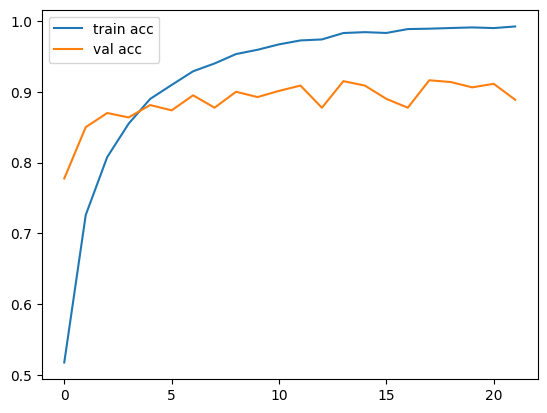

<Figure size 640x480 with 0 Axes>

In [111]:
#loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# best model_resnet50_best_of_best_7_1.h5 83 test val 90

### Save the model

In [34]:
model1.save('test.h5')